In [246]:
import datetime as dt
import thredds_lsasaf_utils as tlu

import pandas as pd
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Point

import rasterio
from rasterio.mask import mask

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.families.links import Power
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log, identity

import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import patsy

import common_utils

In [247]:
# Bounds and parameters
lower_bound = 283.15  # Temperature in Kelvin (e.g., 0°C in Kelvin)
upper_bound = 323.15  # Temperature in Kelvin (e.g., 50°C in Kelvin)
no_data_percent = 0.2  # No data threshold
sample_size = 2000  # Number of random rows to sample

In [248]:
def read_fused_data(filename):

    # Replace 'your_file.csv' with the path to your CSV file
    file_path = filename

    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Ensure the CSV contains 'lat' and 'lon' columns
    if 'lat' not in df.columns or 'lon' not in df.columns:
        raise ValueError("The CSV file must contain 'lat' and 'lon' columns")

    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Set the coordinate reference system (CRS) if known, e.g., WGS84 (EPSG:4326)
    gdf.set_crs(epsg=4326, inplace=True)

    return gdf

In [249]:
# Read data from .csv file
file_path = '../msg_lu_fused_data_for_glm/concatenated_data.gpkg'
gdf =  gpd.read_file(file_path)  # Read the .gpkg file

In [250]:
# Define target and LULC columns
target = 'temperature'  # Replace with your target column name

# Convert to Kelvin
gdf['temperature'] = gdf['temperature'] + 273.15

# Ensure categorical variables are treated as such
gdf['hour'] = gdf['hour'].astype('category')
gdf['month'] = gdf['month'].astype('category')

# Drop the geometry column
gdf = gdf.drop(columns=['geometry'])

# Define LULC columns (all columns except the target)
lulc_columns = ['water', 'trees', 'crop', 'built_area', 'bare_ground', 'range_land']

# Drop rows with missing values
gdf = gdf.dropna(subset=[target, 'hour', 'month'] + lulc_columns)

In [251]:

# Step 2: Filter out rows outside this range
gdf = gdf[(gdf[target] >= lower_bound) & (gdf[target] <= upper_bound)]

# Drops rows with no_data > no_data_precent
gdf = gdf[gdf['no_data'] <= no_data_precent]

In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'gdf' and the 'temperature' column exists
plt.figure(figsize=(8, 6))

# Plotting the histogram for temperature
plt.hist(gdf['temperature'], bins=30, color='skyblue', edgecolor='black')

# Adding title and labels
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
interaction_formula = f"{target} ~ C(month) + C(hour) * ({' + '.join(lulc_columns)})"
interaction_formula

In [ ]:

# Step 2: Split the data into training and testing sets (0.50-0.50 split)
train_data, test_data = train_test_split(gdf, test_size=0.70)

import statsmodels.api as sm

# Step 3: Generate design matrices for train and test sets
y_train, X_train = patsy.dmatrices(interaction_formula, data=train_data, return_type='dataframe')
y_test, X_test = patsy.dmatrices(interaction_formula, data=test_data, return_type='dataframe')

# Step 4: Fit the GLM model on the training data
gamma_model = sm.GLM(y_train, X_train, family=sm.families.Gamma(link=sm.families.links.log()))
gamma_results = gamma_model.fit()

In [ ]:
# Step 5: Display model summary
print(gamma_results.summary())

In [ ]:
# Make predictions on the test data
y_pred = gamma_results.predict(X_test)

# Plot observed vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', label='Data points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Perfect Fit')
plt.xlabel("Observed Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Observed vs Predicted Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pickle

# Save the GLM model to a pickle file
with open('glm_model.pkl', 'wb') as file:
    pickle.dump(gamma_results, file)

print("GLM model saved as 'glm_model.pkl'")

# Save the model summary to a text file
with open('glm_model_summary.txt', 'w') as file:
    file.write(gamma_results.summary().as_text())

print("GLM model summary saved as 'glm_model_summary.txt'")

In [ ]:
import matplotlib.pyplot as plt

# Create a combined 'month-hour' column for better visualization
test_data['month_str'] = test_data['month'].astype(str).str.zfill(2)

test_data['month_hour'] = test_data['month_str'].astype(str) + '-' + test_data['hour'].astype(str)

# Add predictions to the test dataset
test_data['observed'] = y_test.values
test_data['predicted'] = y_pred

# Sort by the combined 'month-hour' index for proper plotting
test_data = test_data.sort_values(by=['month_str', 'hour'])

# Plot observed vs predicted as a time series
plt.figure(figsize=(14, 6))
plt.plot(test_data['month_hour'], test_data['observed'], label='Observed Temperature', marker='o', linestyle='-', color='blue')
plt.plot(test_data['month_hour'], test_data['predicted'], label='Predicted Temperature', marker='x', linestyle='--', color='red')
plt.xlabel('Month-Hour')
plt.ylabel('Temperature')
plt.title('Time Series: Observed vs Predicted Temperature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("Root Mean Squared Error:", round(rmse, 1))

In [ ]:
import os
import geopandas as gpd
import patsy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Directory containing the Ecostress files
ecostress_dir = "../ecostress_lulc_temprature_datetime_fused/"
file_extension = ".gpkg"

# Land use columns and target column
land_use_columns = ['water', 'trees', 'flooded_veg', 'crop', 'built_area', 'bare_ground', 'snow_or_ice', 'clouds', 'range_land']
columns_to_check = land_use_columns + ['no_data']
target = 'temperature'

# Placeholder for RMSE calculation and combined plotting
all_observed = []
all_predicted = []

# Extract only the predictors part of the formula
predictor_formula = interaction_formula.split("~")[1].strip()

# Iterate over all Ecostress files
for file_name in os.listdir(ecostress_dir):
    if file_name.endswith(file_extension):
        ecostress_file = os.path.join(ecostress_dir, file_name)

        print(file_name)
        # Read the file
        new_gdf = gpd.read_file(ecostress_file)

        # Filter for summer months
        new_gdf = new_gdf[new_gdf['month'].isin([6, 7, 8])]

        # Filter rows based on land use and no_data columns
        new_gdf = new_gdf[~(new_gdf[columns_to_check] == 0).all(axis=1)]
        new_gdf = new_gdf[new_gdf['no_data'] <= no_data_percent]

        # Convert temperature to Kelvin
        new_gdf['temperature'] = new_gdf['temperature'] + 273.15

        # Filter rows within the temperature bounds
        new_gdf = new_gdf[(new_gdf[target] >= lower_bound) & (new_gdf[target] <= upper_bound)]

        # Ensure categorical variables
        new_gdf['hour'] = new_gdf['hour'].astype('category')
        new_gdf['month'] = new_gdf['month'].astype('category')

        # Ensure consistent categories
        new_gdf['month'] = pd.Categorical(new_gdf['month'], categories=gdf['month'].unique())
        new_gdf['hour'] = pd.Categorical(new_gdf['hour'], categories=gdf['hour'].unique())

        # Drop rows with missing values
        new_gdf = new_gdf.dropna(subset=['temperature', 'hour', 'month'])

        # Randomly sample 2000 rows
        if len(new_gdf) > sample_size:
            new_gdf = new_gdf.sample(n=sample_size, random_state=42)

        if new_gdf.shape[0] == 0:
            continue

        # Generate design matrix
        X_new = patsy.dmatrix(predictor_formula, data=new_gdf, return_type='dataframe')

        # Make predictions
        predictions = gamma_results.predict(X_new)

        # Cap predictions at bounds
        capped_predictions = np.minimum(np.maximum(predictions, lower_bound), upper_bound)
        new_gdf['predicted'] = capped_predictions

        # Store observed and predicted values for combined plot
        all_observed.extend(new_gdf['temperature'].tolist())
        all_predicted.extend(new_gdf['predicted'].tolist())


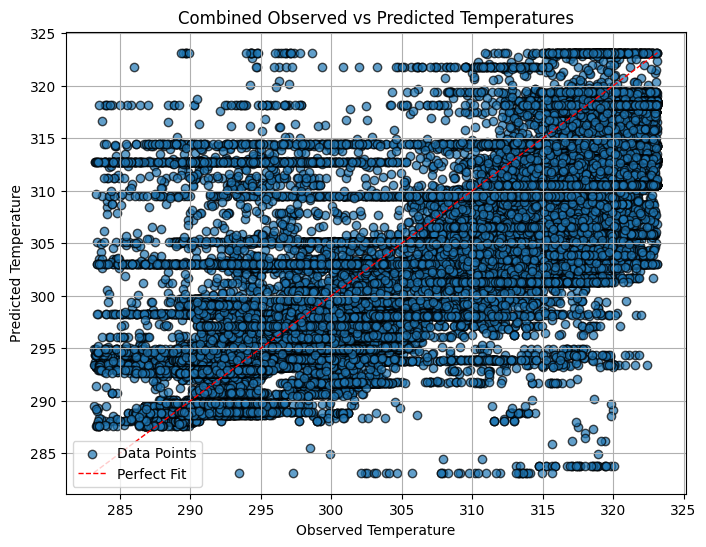

In [263]:

# Plot all observed vs. predicted values in one plot
plt.figure(figsize=(8, 6))
plt.scatter(all_observed, all_predicted, alpha=0.7, edgecolor='k', label='Data Points')

min_val = lower_bound
max_val = upper_bound

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='Perfect Fit')

# Add labels, title, and legend
plt.xlabel('Observed Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Combined Observed vs Predicted Temperatures')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [262]:

# Calculate and print overall RMSE
rmse = np.sqrt(mean_squared_error(all_observed, all_predicted))
print(f"Overall RMSE: {rmse}")


Overall RMSE: 7.435707705719605


In [261]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

def calculate_rmsle(actual, predicted):
    """
    Calculate Root Mean Squared Logarithmic Error (RMSLE) using scikit-learn.

    Parameters:
        actual (array-like): The actual observed values.
        predicted (array-like): The predicted values.

    Returns:
        float: The RMSLE value.
    """
    # Ensure the values are positive (to avoid log issues)
    actual = np.maximum(0, actual)  # Negative values are clipped to 0
    predicted = np.maximum(0, predicted)  # Negative values are clipped to 0

    # Calculate Mean Squared Logarithmic Error
    msle = mean_squared_log_error(actual, predicted)
    rmsle = np.sqrt(msle)
    return rmsle


rmsle_value = calculate_rmsle(all_observed, all_predicted)
print(f"RMSLE: {rmsle_value}")


RMSLE: 0.02419919082758934
